# Exploratory Data Analysis

## Statistical Profiling
This notebook performs initial data quality assessment and outlier detection using **IsolationForest** (anomaly detection algorithm). We identify listings with unusual price/rating combinations that might represent data errors or luxury properties requiring separate analysis

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest

## Visualization Strategy
We use **Seaborn** and **Matplotlib** for:
- Price distribution histograms (by city)
- Correlation heatmaps (price vs. distance/rating/guests)

These insights inform Power BI dashboard design (which visualizations add business value vs. which are just exploratory noise).

In [10]:
df = pd.read_csv("transformed_data/final_data.csv")
df.head(5)

price_total     room_type  is_shared_room  is_private_room  max_guests  \
0   194.033698  Private room               0                1         2.0   
1   344.245776  Private room               0                1         4.0   
2   264.101422  Private room               0                1         2.0   
3   433.529398  Private room               0                1         4.0   
4   485.552926  Private room               0                1         2.0   

   is_superhost  is_multi_listing  is_business_listing  cleanliness_score  \
0             0                 1                    0               10.0   
1             0                 0                    0                8.0   
2             0                 0                    1                9.0   
3             0                 0                    1                9.0   
4             1                 0                    0               10.0   

   guest_satisfaction_score  ...  Crime_Index  Safety_Index  \
0                      93.0  ...         25.7          74.3   
1                      85.0  ...         25.7          74.3   
2                      87.0  ...         25.7          74.3   
3                      90.0  ...         25.7          74.3   
4                      98.0  ...         25.7          74.3   

   Monthly_Average_Net_salary  Meal_at_Inexpensive_Restaurant  \
0                      4502.1                            20.5   
1                      4502.1                            20.5   
2                      4502.1                            20.5   
3                      4502.1                            20.5   
4                      4502.1                            20.5   

   Taxi_price_per_Km  Monthly_Basic_Utilities  Monthly_Rent_One_Bedroom_CC  \
0                3.0                    262.0                      2178.68   
1                3.0                    262.0                      2178.68   
2                3.0                    262.0                      2178.68   
3                3.0                    262.0                      2178.68   
4                3.0                    262.0                      2178.68   

   Monthly_Rent_One_Bedroom_OCC  Monthly_Rent_Three_Bedroom_CC  \
0                       1701.26                         3725.5   
1                       1701.26                         3725.5   
2                       1701.26                         3725.5   
3                       1701.26                         3725.5   
4                       1701.26                         3725.5   

  Monthly_Rent_Three_Bedroom_OCC  
0                        2785.29  
1                        2785.29  
2                        2785.29  
3                        2785.29  
4                        2785.29  

[5 rows x 35 columns]

In [20]:
df.room_type.value_counts()

room_type
Entire home/apt    32648
Private room       18693
Shared room          366
Name: count, dtype: int64

### **Data Dictionary**

| Column Name | Description |
| --- | --- |
| **`price_total`** | Total price of the listing per stay |
| **`room_type`** | Type of accommodation (e.g., Private room, Entire home) |
| **`is_shared_room`** | Indicates whether the room is shared with others (`True`/`False`) |
| **`is_private_room`** | Indicates whether the room is private (`True`/`False`) |
| **`max_guests`** | Maximum number of guests the listing can accommodate |
| **`is_superhost`** | Indicates if the host is a Superhost (`True`/`False`) |
| **`is_multi_listing`** | Indicates whether the host manages multiple listings |
| **`is_business_listing`** | Indicates whether the listing is suitable for business travel |
| **`cleanliness_score`** | Cleanliness rating given by guests (scale 0-10) |
| **`guest_satisfaction_score`** | Overall guest satisfaction rating (scale 0-100) |
| **`num_bedrooms`** | Number of bedrooms in the listing |
| **`distance_city_center`** | Distance of the listing from the city center (km) |
| **`distance_metro`** | Distance from the nearest metro station (km) |
| **`attraction_index`** | Index measuring proximity to tourist attractions |
| **`attraction_index_norm`** | Normalized attraction proximity score |
| **`restaurant_index`** | Index measuring proximity to restaurants |
| **`restaurant_index_norm`** | Normalized restaurant proximity score |
| **`longitude`** | Longitude coordinate of the listing |
| **`latitude`** | Latitude coordinate of the listing |
| **`city`** | City where the listing is located |
| **`day_type`** | Indicates whether the data corresponds to a weekday or weekend |
| **`district`** | District or neighborhood within the city |
| **`state`** | State or administrative region where the city is located |
| **`country_code`** | Two-letter country code (e.g., NL, FR, UK) |
| **`country_name`** | Full name of the country |
| **`Crime_Index`** | Estimate of overall crime level in the city (0-100 scale) |
| **`Safety_Index`** | Estimate of overall safety in the city (0-100 scale) |
| **`Monthly_Average_Net_salary`** | Average monthly net salary (after tax) for the city |
| **`Meal_at_Inexpensive_Restaurant`** | Average price of a meal at an inexpensive restaurant |
| **`Taxi_price_per_Km`** | Standard taxi tariff per kilometer in the city |
| **`Monthly_Basic_Utilities`** | Avg monthly cost for basic utilities (Electricity, Heating, Water, etc.) |
| **`Monthly_Rent_One_Bedroom_CC`** | Avg monthly rent for a 1-bedroom apartment in City Center |
| **`Monthly_Rent_One_Bedroom_OCC`** | Avg monthly rent for a 1-bedroom apartment Outside City Center |
| **`Monthly_Rent_Three_Bedroom_CC`** | Avg monthly rent for a 3-bedroom apartment in City Center |
| **`Monthly_Rent_Three_Bedroom_OCC`** | Avg monthly rent for a 3-bedroom apartment Outside City Center |

In [11]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_total                     51707 non-null  float64
 1   room_type                       51707 non-null  str    
 2   is_shared_room                  51707 non-null  int64  
 3   is_private_room                 51707 non-null  int64  
 4   max_guests                      51707 non-null  float64
 5   is_superhost                    51707 non-null  int64  
 6   is_multi_listing                51707 non-null  int64  
 7   is_business_listing             51707 non-null  int64  
 8   cleanliness_score               51707 non-null  float64
 9   guest_satisfaction_score        51707 non-null  float64
 10  num_bedrooms                    51707 non-null  int64  
 11  distance_city_center            51707 non-null  float64
 12  distance_metro                  51707 non-n

In [46]:
df.columns.unique()

Index(['price_total', 'room_type', 'is_shared_room', 'is_private_room',
       'max_guests', 'is_superhost', 'is_multi_listing', 'is_business_listing',
       'cleanliness_score', 'guest_satisfaction_score', 'num_bedrooms',
       'distance_city_center', 'distance_metro', 'attraction_index',
       'attraction_index_norm', 'restaurant_index', 'restaurant_index_norm',
       'longitude', 'latitude', 'city', 'day_type', 'district', 'state',
       'country_code', 'country_name', 'Crime_Index', 'Safety_Index',
       'Monthly_Average_Net_salary', 'Meal_at_Inexpensive_Restaurant',
       'Taxi_price_per_Km', 'Monthly_Basic_Utilities',
       'Monthly_Rent_One_Bedroom_CC', 'Monthly_Rent_One_Bedroom_OCC',
       'Monthly_Rent_Three_Bedroom_CC', 'Monthly_Rent_Three_Bedroom_OCC'],
      dtype='str')

In [12]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # 1. Initialize the Scaler to convert distances to 0-1 range
# scaler = MinMaxScaler()

# # 2. Normalize the raw distances so they are comparable
# # We create temporary columns for the calculation
# df['norm_dist_center'] = scaler.fit_transform(df[['distance_city_center']])
# df['norm_dist_metro'] = scaler.fit_transform(df[['distance_metro']])

# # 3. Calculate the Convenience Score (Weighted)
# # We invert them (1 - dist) because Low Distance = High Score
# # Weight: 70% importance to City Center, 30% to Metro
# df['convenience_score'] = (
#     0.7 * (1 - df['norm_dist_center']) + 
#     0.3 * (1 - df['norm_dist_metro'])
# ) * 10  # Scale to 0-10

# # Optional: Round to 2 decimals for cleaner reading
# df['convenience_score'] = df['convenience_score'].round(2)

In [13]:
# import pandas as pd

# # 1. Define your strict numerical boundaries
# # Ranges: 0-20, 20-50, 50-100+
# # We use infinity for the upper bound to catch any outliers > 100
# bins = [0, 20, 50, float('inf')] 

# # 2. Define the labels for these ranges
# labels = ['Quiet Zone', 'Moderate', 'Tourist Hub']

# # 3. Apply pd.cut
# df['attraction_density'] = pd.cut(
#     df['attraction_index_norm'], 
#     bins=bins, 
#     labels=labels,
#     include_lowest=True  # Important: ensures values of exactly 0 are included
# )

# # 4. Check the distribution (you might find 'Tourist Hub' has fewer items now)
# print(df['attraction_density'].value_counts())

In [27]:
#make lapel encoding for day_type for corr let it one column is_weekend or no
df_spare = df.copy()
df_spare['is_weekend'] = df['day_type'].apply(lambda x: 1 if x == 'weekend' else 0)


In [28]:
df_spare

price_total        room_type  is_shared_room  is_private_room  \
0       194.033698     Private room               0                1   
1       344.245776     Private room               0                1   
2       264.101422     Private room               0                1   
3       433.529398     Private room               0                1   
4       485.552926     Private room               0                1   
...            ...              ...             ...              ...   
51702   715.938574  Entire home/apt               0                0   
51703   304.793960  Entire home/apt               0                0   
51704   637.168969  Entire home/apt               0                0   
51705   301.054157     Private room               0                1   
51706   133.230489     Private room               0                1   

       max_guests  is_superhost  is_multi_listing  is_business_listing  \
0             2.0             0                 1                    0   
1             4.0             0                 0                    0   
2             2.0             0                 0                    1   
3             4.0             0                 0                    1   
4             2.0             1                 0                    0   
...           ...           ...               ...                  ...   
51702         6.0             0                 0                    1   
51703         2.0             0                 0                    0   
51704         2.0             0                 0                    0   
51705         2.0             0                 0                    0   
51706         4.0             1                 1                    0   

       cleanliness_score  guest_satisfaction_score  ...  Safety_Index  \
0                   10.0                      93.0  ...          74.3   
1                    8.0                      85.0  ...          74.3   
2                    9.0                      87.0  ...          74.3   
3                    9.0                      90.0  ...          74.3   
4                   10.0                      98.0  ...          74.3   
...                  ...                       ...  ...           ...   
51702               10.0                     100.0  ...          71.6   
51703                8.0                      86.0  ...          71.6   
51704               10.0                      93.0  ...          71.6   
51705               10.0                      87.0  ...          71.6   
51706               10.0                      93.0  ...          71.6   

       Monthly_Average_Net_salary  Meal_at_Inexpensive_Restaurant  \
0                          4502.1                           20.50   
1                          4502.1                           20.50   
2                          4502.1                           20.50   
3                          4502.1                           20.50   
4                          4502.1                           20.50   
...                           ...                             ...   
51702                      3135.2                           18.25   
51703                      3135.2                           18.25   
51704                      3135.2                           18.25   
51705                      3135.2                           18.25   
51706                      3135.2                           18.25   

       Taxi_price_per_Km  Monthly_Basic_Utilities  \
0                    3.0                    262.0   
1                    3.0                    262.0   
2                    3.0                    262.0   
3                    3.0                    262.0   
4                    3.0                    262.0   
...                  ...                      ...   
51702                1.9                    291.2   
51703                1.9                    291.2   
51704                1.9                    291.2   
51705            

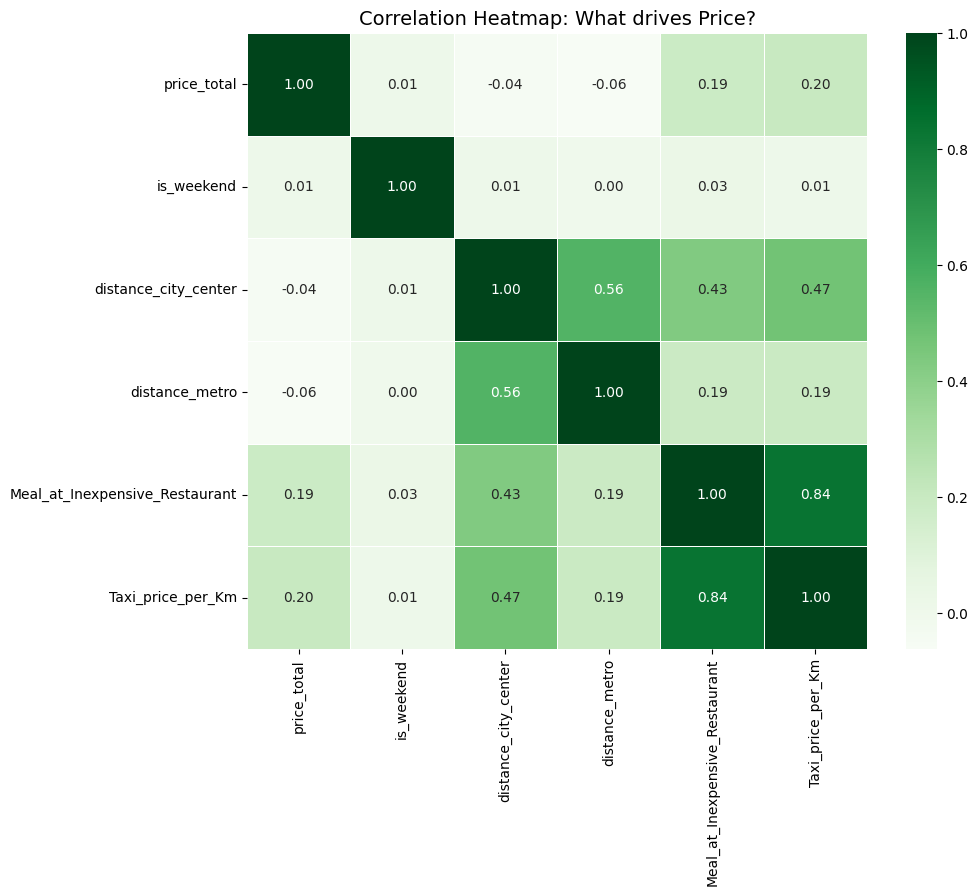

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols=[
  'price_total', "is_weekend",
    'distance_city_center', 'distance_metro', 
    "Meal_at_Inexpensive_Restaurant",
    "Taxi_price_per_Km",
]


plt.figure(figsize=(10, 8))
sns.heatmap(df_spare[numeric_cols].corr(), annot=True, cmap='Greens', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: What drives Price?', fontsize=14)
plt.show()

In [44]:
from operator import index


df_spare.pivot_table(index=['city','is_superhost'], values='price_total', aggfunc=['median', 'count', 'mean','max','min'])

median       count        mean           max  \
                       price_total price_total price_total   price_total   
city      is_superhost                                                     
Amsterdam 0             479.460080        1489  586.481321   8130.668104   
          1             405.642912         591  539.431349   2771.541724   
Athens    0             123.965974        3017  142.883451    869.167858   
          1             136.854686        2263  163.557044  18545.450285   
Barcelona 0             203.644658        2319  292.919726   6943.700980   
          1             219.819862         514  297.516355   1770.661205   
Berlin    0             191.408806        1845  241.646405   2319.341872   
          1             186.500888         639  253.064825   5857.483407   
Budapest  0             153.217089        2498  180.989554   3751.233727   
          1             152.747098        1524  169.176894    929.407341   
Lisbon    0             221.857411        4530  234.005163   1681.050657   
          1             238.039400        1233  253.660667    876.407129   
London    0             269.056187        8420  365.378641  12937.275101   
          1             237.305675        1573  346.895813  15499.894165   
Paris     0             312.936900        5747  389.509288  16445.614689   
          1             340.898499         941  410.988463   2086.401342   
Rome      0             178.851144        6078  202.558988   2418.348023   
          1             188.436631        2949  211.230790   1119.163959   
Vienna    0             203.468667        2532  243.722878  13664.305916   
          1             214.571208        1005  236.189969    811.771031   

                               min  
                       price_total  
city      is_superhost              
Amsterdam 0             128.887118  
          1             165.678532  
Athens    0              42.884259  
          1              45.227662  
Barcelona 0              69.588289  
          1              80.992390  
Berlin    0              71.982799  
          1              64.971487  
Budapest  0              34.779339  
          1              53.343986  
Lisbon    0              70.590994  
          1              72.701689  
London    0              54.328653  
          1              56.680543  
Paris     0              92.739305  
          1             107.652158  
Rome      0              46.057092  
          1              66.864611  
Vienna    0              63.576654  
          1              81.340719

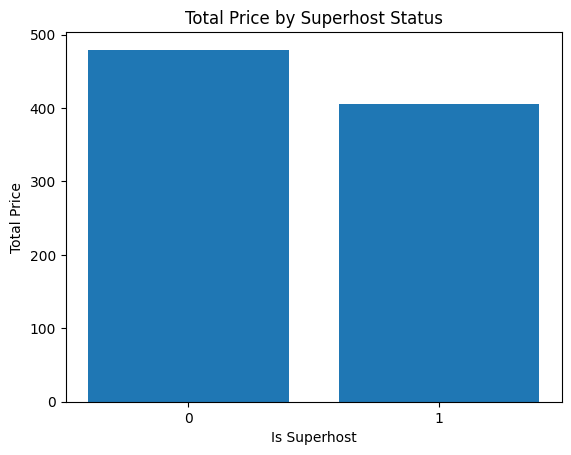

In [40]:
superhost_price = (
    df_spare
    .groupby(["city","is_superhost"])["price_total"].median()
    .reset_index()
)
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    superhost_price["is_superhost"].astype(str),
    superhost_price["price_total"]
)

plt.xlabel("Is Superhost")
plt.ylabel("Total Price")
plt.title("Total Price by Superhost Status")

plt.show()

In [18]:
import plotly.express as px

# Get the list of unique cities
cities = df['city'].unique()

# Loop through each city
for city in cities:
    print(f"Generating map for: {city}...")
    
    # 1. Filter for the current city
    city_df = df[df['city'] == city].copy()
    
    # 2. Cap outliers LOCALLY
    price_cap = city_df['price_total'].quantile(0.95)
    city_df = city_df[city_df['price_total'] < price_cap]
    
    # 3. Create the Map
    fig = px.scatter_mapbox(
        city_df,
        lat="latitude",
        lon="longitude",
        color="price_total",
        size="guest_satisfaction_score",
        hover_name="room_type",
        # FIX: Changed 'dist_city_center' to 'distance_city_center'
        hover_data=["distance_city_center", "attraction_index_norm"], 
        color_continuous_scale=px.colors.sequential.Magma,
        zoom=10, 
        height=800,
        size_max=8,
        title=f"Listing Prices & Satisfaction in {city}"
    )
    
    fig.update_layout(mapbox_style="carto-positron")
    
    # 4. Show the map
    fig.show()

Generating map for: Amsterdam...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Athens...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Barcelona...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Berlin...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Budapest...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Lisbon...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: London...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Paris...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Rome...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Generating map for: Vienna...


C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_19784\1782880902.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

